In [1]:
# Pandas is used for data manipulation
import pandas as pd
# Read in data and display first 5 rows
features = pd.read_csv('woody_degrad.csv')
features.head(5)

,dem,dist2canal,saltwater_max,groundwater_max,gw_duration,degradation
0,0.38054,1471.223980,-0.219789,-0.004625,1.000000,1
1,0.23622,1500.299970,-0.071583,0.123283,1.000000,1
2,0.33377,1530.294089,-0.169133,0.025733,1.000000,1
3,0.47378,1560.288435,-0.307434,-0.192245,0.986301,1
4,0.34838,1500.000000,-0.188293,0.090398,0.920548,1


In [2]:
print('The shape of our features is:', features.shape)

The shape of our features is: (15404, 6)


In [3]:
features = pd.DataFrame(features)

In [4]:
features

,dem,dist2canal,saltwater_max,groundwater_max,gw_duration,degradation
0,0.380540,1471.223980,-0.219789,-0.004625,1.000000,1
1,0.236220,1500.299970,-0.071583,0.123283,1.000000,1
2,0.333770,1530.294089,-0.169133,0.025733,1.000000,1
3,0.473780,1560.288435,-0.307434,-0.192245,0.986301,1
4,0.348380,1500.000000,-0.188293,0.090398,0.920548,1
...,...,...,...,...,...,...
15399,0.484160,3761.980861,-0.290103,-0.082835,0.877049,2
15400,0.041831,3853.336217,0.219596,0.314767,0.268493,2
15401,0.008813,3812.833592,0.232474,0.325290,0.235616,2
15402,0.021208,3805.390913,0.201926,0.347551,0.243836,2


In [5]:
features['degradation'].value_counts()

1    13219
2     2185
Name: degradation, dtype: int64

In [6]:
from sklearn.utils import resample
#  分离多数和少数类别
df_majority = features[features.degradation==1]
df_minority = features[features.degradation==2]

# 上采样少数类别
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=13219,   # to match majority class
                                 random_state=123) # reproducible results

# 合并多数类别同上采样过的少数类别
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# 显示新的类别数量
df_upsampled.degradation.value_counts()

1    13219
2    13219
Name: degradation, dtype: int64

In [7]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we "want to predict
labels = np.array(df_upsampled['degradation'])
# Remove the labels from the features
# axis 1 refers to the columns
df_upsampled= df_upsampled.drop('degradation', axis = 1)
# Saving feature names for later use
feature_list = list(df_upsampled.columns)
# Convert to numpy array
features = np.array(df_upsampled)

In [8]:
features.shape

(26438, 5)

In [9]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [10]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (19828, 5)
Training Labels Shape: (19828,)
Testing Features Shape: (6610, 5)
Testing Labels Shape: (6610,)


In [11]:
from collections import Counter
d = Counter(train_labels)
d_s = sorted(d.items(),key=lambda x:x[1],reverse=True)
print(f'这个值：{d_s[0][0]}出现的次数最多，为{d_s[0][1]}次')

这个值：2出现的次数最多，为9943次


In [12]:
# Import the model we are using
import sklearn.ensemble
# Instantiate model with 3 decision trees
clf1 = sklearn.ensemble.RandomForestClassifier(n_estimators=3, random_state=21)
clf1 = clf1.fit(train_features, train_labels);
acc1 = clf1.score(test_features,test_labels)
print('Accuracy:',clf1.score(test_features,test_labels))

# Instantiate model with 5 decision trees
clf2 = sklearn.ensemble.RandomForestClassifier(n_estimators=5, random_state=21)
clf2 = clf2.fit(train_features, train_labels);
acc2 = clf2.score(test_features,test_labels)
print('Accuracy:',clf2.score(test_features,test_labels))

# Instantiate model with 10 decision trees
clf3 = sklearn.ensemble.RandomForestClassifier(n_estimators=10, random_state=21)
clf3 = clf3.fit(train_features, train_labels);
acc3 = clf3.score(test_features,test_labels)
print('Accuracy:',clf3.score(test_features,test_labels))

# Instantiate model with 20 decision trees
clf4 = sklearn.ensemble.RandomForestClassifier(n_estimators=20, random_state=21)
clf4 = clf4.fit(train_features, train_labels);
acc4 = clf4.score(test_features,test_labels)
print('Accuracy:',clf4.score(test_features,test_labels))

# Instantiate model with 30 decision trees
clf5 = sklearn.ensemble.RandomForestClassifier(n_estimators=30, random_state=21)
clf5 = clf5.fit(train_features, train_labels);
acc5 = clf5.score(test_features,test_labels)
print('Accuracy:',clf5.score(test_features,test_labels))

# Instantiate model with 40 decision trees
clf6 = sklearn.ensemble.RandomForestClassifier(n_estimators=40, random_state=21)
clf6 = clf6.fit(train_features, train_labels);
acc6 = clf6.score(test_features,test_labels)
print('Accuracy:',clf6.score(test_features,test_labels))

# Instantiate model with 50 decision trees
clf7 = sklearn.ensemble.RandomForestClassifier(n_estimators=50, random_state=21)
clf7 = clf7.fit(train_features, train_labels);
acc7 = clf7.score(test_features,test_labels)
print('Accuracy:',clf7.score(test_features,test_labels))

# Instantiate model with 60 decision trees
clf8 = sklearn.ensemble.RandomForestClassifier(n_estimators=60, random_state=21)
clf8 = clf8.fit(train_features, train_labels);
acc8 = clf8.score(test_features,test_labels)
print('Accuracy:',clf8.score(test_features,test_labels))

# Instantiate model with 70 decision trees
clf9 = sklearn.ensemble.RandomForestClassifier(n_estimators=70, random_state=21)
clf9 = clf9.fit(train_features, train_labels);
acc9 = clf9.score(test_features,test_labels)
print('Accuracy:',clf9.score(test_features,test_labels))

# Instantiate model with 80 decision trees
clf10 = sklearn.ensemble.RandomForestClassifier(n_estimators=80, random_state=21)
clf10 = clf10.fit(train_features, train_labels);
acc10 = clf10.score(test_features,test_labels)
print('Accuracy:',clf10.score(test_features,test_labels))

# Instantiate model with 90 decision trees
clf11 = sklearn.ensemble.RandomForestClassifier(n_estimators=90, random_state=21)
clf11 = clf11.fit(train_features, train_labels);
acc11 = clf11.score(test_features,test_labels)
print('Accuracy:',clf11.score(test_features,test_labels))

# Instantiate model with 100 decision trees
clf12 = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=21)
clf12 = clf12.fit(train_features, train_labels);
acc12 = clf12.score(test_features,test_labels)
print('Accuracy:',clf12.score(test_features,test_labels))

# Instantiate model with 200 decision trees
clf13 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, random_state=21)
clf13 = clf13.fit(train_features, train_labels);
acc13 = clf13.score(test_features,test_labels)
print('Accuracy:',clf13.score(test_features,test_labels))

# Instantiate model with 300 decision trees
clf14 = sklearn.ensemble.RandomForestClassifier(n_estimators=300, random_state=21)
clf14 = clf14.fit(train_features, train_labels);
acc14 = clf14.score(test_features,test_labels)
print('Accuracy:',clf14.score(test_features,test_labels))

# Instantiate model with 400 decision trees
clf15 = sklearn.ensemble.RandomForestClassifier(n_estimators=400, random_state=21)
clf15 = clf15.fit(train_features, train_labels);
acc15 = clf15.score(test_features,test_labels)
print('Accuracy:',clf15.score(test_features,test_labels))

# Instantiate model with 500 decision trees
clf16 = sklearn.ensemble.RandomForestClassifier(n_estimators=500, random_state=21)
clf16 = clf16.fit(train_features, train_labels);
acc16 = clf16.score(test_features,test_labels)
print('Accuracy:',clf16.score(test_features,test_labels))

# Instantiate model with 1000 decision trees
clf17 = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, random_state=21)
clf17 = clf17.fit(train_features, train_labels);
acc17 = clf17.score(test_features,test_labels)
print('Accuracy:',clf17.score(test_features,test_labels))

# Instantiate model with 1500 decision trees
clf18 = sklearn.ensemble.RandomForestClassifier(n_estimators=1500, random_state=21)
clf18 = clf18.fit(train_features, train_labels);
acc18 = clf18.score(test_features,test_labels)
print('Accuracy:',clf18.score(test_features,test_labels))

# Instantiate model with 2000 decision trees
clf19 = sklearn.ensemble.RandomForestClassifier(n_estimators=2000, random_state=21)
clf19 = clf19.fit(train_features, train_labels);
acc19 = clf19.score(test_features,test_labels)
print('Accuracy:',clf19.score(test_features,test_labels))

Accuracy: 0.9444780635400908
Accuracy: 0.9508320726172466
Accuracy: 0.9665658093797277
Accuracy: 0.9680786686838124
Accuracy: 0.9688350983358548
Accuracy: 0.9694402420574887
Accuracy: 0.9698940998487141
Accuracy: 0.970499243570348
Accuracy: 0.970499243570348
Accuracy: 0.9691376701966717
Accuracy: 0.9703479576399395
Accuracy: 0.970196671709531
Accuracy: 0.9697428139183056
Accuracy: 0.9698940998487141
Accuracy: 0.970196671709531
Accuracy: 0.970801815431165
Accuracy: 0.970196671709531
Accuracy: 0.9703479576399395
Accuracy: 0.970196671709531


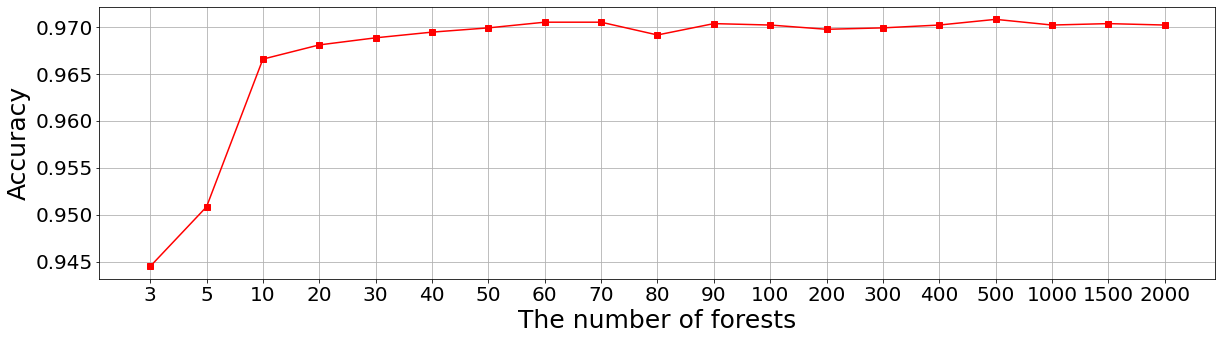

In [13]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
y = [acc1, acc2, acc3, acc4, acc5, acc6, acc7, acc8, acc9, acc10, acc11, acc12, acc13, acc14, acc15, acc16, acc17, acc18, acc19]
plt.figure(figsize = (20, 5)) 
plt.plot(x,y,'s-',color = 'r')
plt.xlabel("The number of forests", fontdict={'size':25})#横坐标名字
plt.ylabel("Accuracy", fontdict={'size':25})#纵坐标名字
plt.xticks(x, ('3','5','10','20','30','40','50','60','70','80','90','100','200','300','400','500','1000', '1500', '2000'), size=20)
plt.yticks(size = 20)
plt.grid()
plt.show()

In [14]:
# Import the model we are using
import sklearn.ensemble
# Instantiate model with 500 decision trees
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=500, random_state=21)
# Train the model on training data
clf = clf.fit(train_features, train_labels);

In [15]:
# Use the forest's predict method on the test data
predictions = clf.predict(test_features)
#Assess the accuracy using the validation dataset
print('Accuracy:',clf.score(test_features,test_labels))

Accuracy: 0.970801815431165


In [16]:
from sklearn.metrics import roc_auc_score
prob_y = clf.predict_proba(test_features)
prob_y = [p[1] for p in prob_y]
print(roc_auc_score(test_labels, prob_y))

0.9979547588650768


In [17]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: dist2canal           Importance: 0.29
Variable: dem                  Importance: 0.2
Variable: saltwater_max        Importance: 0.2
Variable: groundwater_max      Importance: 0.18
Variable: gw_duration          Importance: 0.13


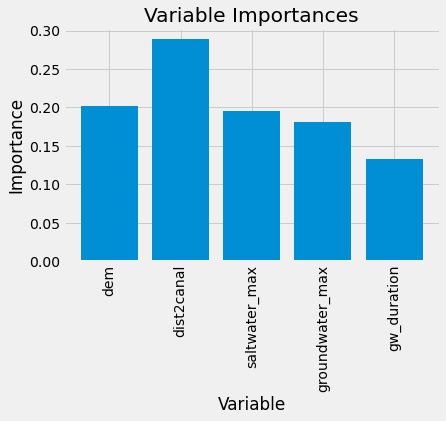

In [18]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');